# 🔬 Sesi 4.1 · Data Cleaning & Transformation

Notebook ini mengikuti materi `slides/04_session4_advanced.md` bagian Data Cleaning & Transformation.

## 🎯 Tujuan
- Deteksi & treatment missing values
- Deteksi & treatment outliers (IQR, Z-score)
- Encoding kolom kategorikal
- Feature engineering (tanggal, binning, teks)
- Data quality report & ekspor dataset bersih

## 🛠️ Setup Environment
```bash
uv sync
uv run jupyter notebook

# manual
python -m venv .venv
source .venv/bin/activate   # macOS/Linux
.venv\Scripts\activate    # Windows
pip install pandas numpy seaborn matplotlib scipy scikit-learn missingno
```

In [19]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

try:
    import missingno as msno
    HAS_MISSINGNO = True
except ImportError:
    HAS_MISSINGNO = False

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

## 📁 Load Dataset RUP 2025

In [20]:
DATASET_FILENAME = 'RUP-PaketPenyedia-Terumumkan-2025.parquet'
candidate_paths = [
    Path('../../../datasets/rup') / DATASET_FILENAME,
    Path('../../datasets/rup') / DATASET_FILENAME,
    Path('../datasets/rup') / DATASET_FILENAME,
    Path('datasets/rup') / DATASET_FILENAME,
]
for path in candidate_paths:
    if path.exists():
        DATA_PATH = path.resolve()
        break
else:
    raise FileNotFoundError('Dataset RUP 2025 tidak ditemukan. Pastikan folder datasets tersedia.')

print(f'Dataset path: {DATA_PATH}')
df_raw = pd.read_parquet(DATA_PATH)
df = df_raw.copy()
df['tgl_pengumuman_paket'] = pd.to_datetime(df['tgl_pengumuman_paket'], errors='coerce')
print(df.shape)
df.head()

Dataset path: /home/rizko/coding/python/project/data-science/datasets/rup/RUP-PaketPenyedia-Terumumkan-2025.parquet
(16430, 48)


,tahun_anggaran,kd_klpd,nama_klpd,jenis_klpd,kd_satker,kd_satker_str,nama_satker,kd_rup,nama_paket,pagu,...,status_umumkan_rup,status_dikecualikan,alasan_dikecualikan,tahun_pertama,kode_rup_tahun_pertama,nomor_kontrak,spp_aspek_ekonomi,spp_aspek_sosial,spp_aspek_lingkungan,_event_date
0,2025,D197,Provinsi Kalimantan Barat,PROVINSI,264455,1.02.0.00.0.00.03.0000,RUMAH SAKIT JIWA PROVINSI KALIMANTAN BARAT,53540979,Belanja Bahan Makanan dan Minuman Pasien,7700000000,...,Terumumkan,False,,None,None,None,False,False,False,2025-11-05
1,2025,D197,Provinsi Kalimantan Barat,PROVINSI,264456,1.03.0.00.0.00.01.0000,DINAS PEKERJAAN UMUM DAN PENATAAN RUANG PROVIN...,53688068,Perencanaan Rehabilitasi Gedung UPT Pengujian ...,300000000,...,Terumumkan,False,None,None,None,None,False,False,False,2025-11-05
2,2025,D197,Provinsi Kalimantan Barat,PROVINSI,264456,1.03.0.00.0.00.01.0000,DINAS PEKERJAAN UMUM DAN PENATAAN RUANG PROVIN...,53699505,PENGAWASAN TEKNIS PENGGANTIAN/PEMBANGUNAN JEMB...,1200000000,...,Terumumkan,False,None,None,None,None,True,True,True,2025-11-05
3,2025,D197,Provinsi Kalimantan Barat,PROVINSI,264456,1.03.0.00.0.00.01.0000,DINAS PEKERJAAN UMUM DAN PENATAAN RUANG PROVIN...,53700150,PENGAWASAN TEKNIS PENINGKATAN JALAN TANJUNG M...,1200000000,...,Terumumkan,False,None,None,None,None,True,True,True,2025-11-05
4,2025,D197,Provinsi Kalimantan Barat,PROVINSI,264456,1.03.0.00.0.00.01.0000,DINAS PEKERJAAN UMUM DAN PENATAAN RUANG PROVIN...,53700183,PENGAWASAN TEKNIS PENINGKATAN JALAN MARAU AIR...,1500000000,...,Terumumkan,False,None,None,None,None,True,True,True,2025-11-05


## 🔍 Data Quality Snapshot

In [21]:
print('Rows:', len(df))
print('Columns:', len(df.columns))
print('Memory usage (MB):', df.memory_usage(deep=True).sum()/1024**2)
print('Data types:')
print(df.dtypes.value_counts())
df.info()

Rows: 16430
Columns: 48
Memory usage (MB): 31.813624382019043
Data types:
object            35
bool               6
int64              5
float64            1
datetime64[us]     1
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16430 entries, 0 to 16429
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   tahun_anggaran          16430 non-null  int64         
 1   kd_klpd                 16430 non-null  object        
 2   nama_klpd               16430 non-null  object        
 3   jenis_klpd              16430 non-null  object        
 4   kd_satker               16430 non-null  int64         
 5   kd_satker_str           16430 non-null  object        
 6   nama_satker             16430 non-null  object        
 7   kd_rup                  16430 non-null  int64         
 8   nama_paket              16430 non-null  object        
 9   pagu                 

## 🕵️ Missing Values Detection

In [22]:
missing_summary = (
    df.isnull().sum()
    .to_frame('missing_count')
    .assign(missing_pct=lambda x: x['missing_count'] / len(df) * 100,
            dtype=df.dtypes)
    .sort_values('missing_pct', ascending=False)
)
missing_summary = missing_summary[missing_summary['missing_count'] > 0]
missing_summary.head(15)

,missing_count,missing_pct,dtype
kode_rup_tahun_pertama,16430,100.000000,object
nomor_kontrak,16430,100.000000,object
tahun_pertama,16430,100.000000,object
kd_rup_lokal,16430,100.000000,object
kd_rup_swakelola,16416,99.914790,float64
alasan_non_ukm,16362,99.586123,object
alasan_dikecualikan,16112,98.064516,object
nip_ppk,39,0.237371,object
username_ppk,39,0.237371,object
nama_ppk,39,0.237371,object


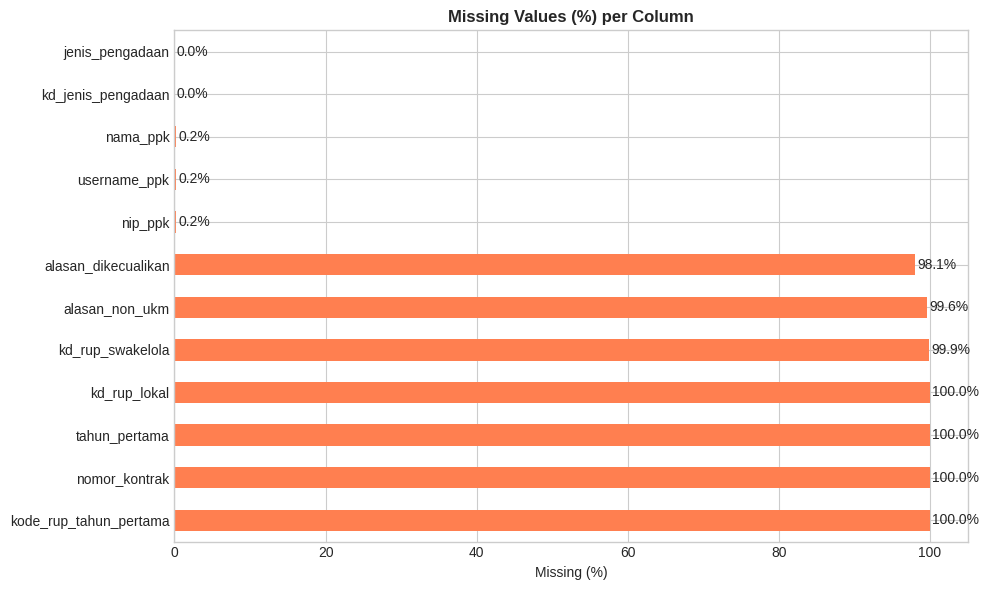

In [23]:
if not missing_summary.empty:
    ax = missing_summary['missing_pct'].plot(kind='barh', figsize=(10,6), color='coral')
    ax.set_title('Missing Values (%) per Column', fontweight='bold')
    ax.set_xlabel('Missing (%)')
    for patch in ax.patches:
        ax.text(patch.get_width()+0.3, patch.get_y()+patch.get_height()/2,
                f"{patch.get_width():.1f}%", va='center')
    plt.tight_layout()
    plt.show()
else:
    print('No missing values detected ✅')

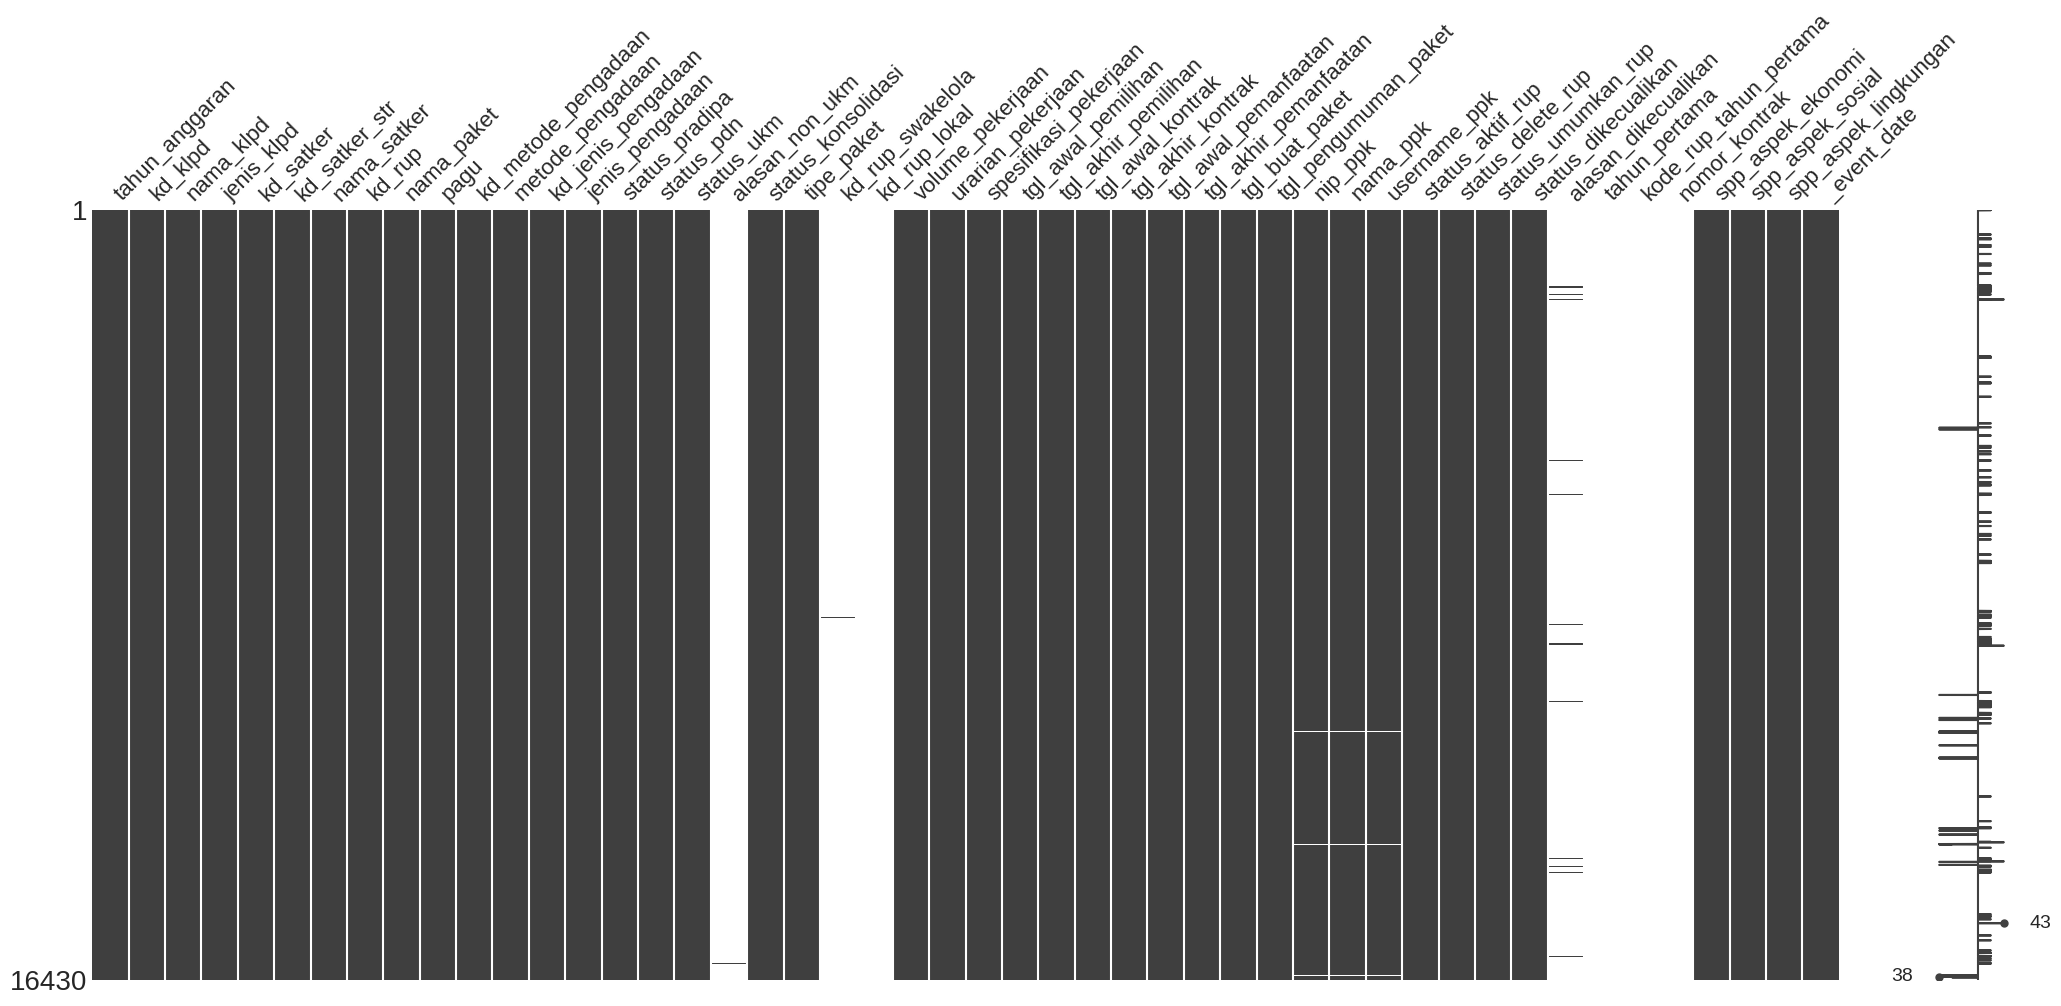

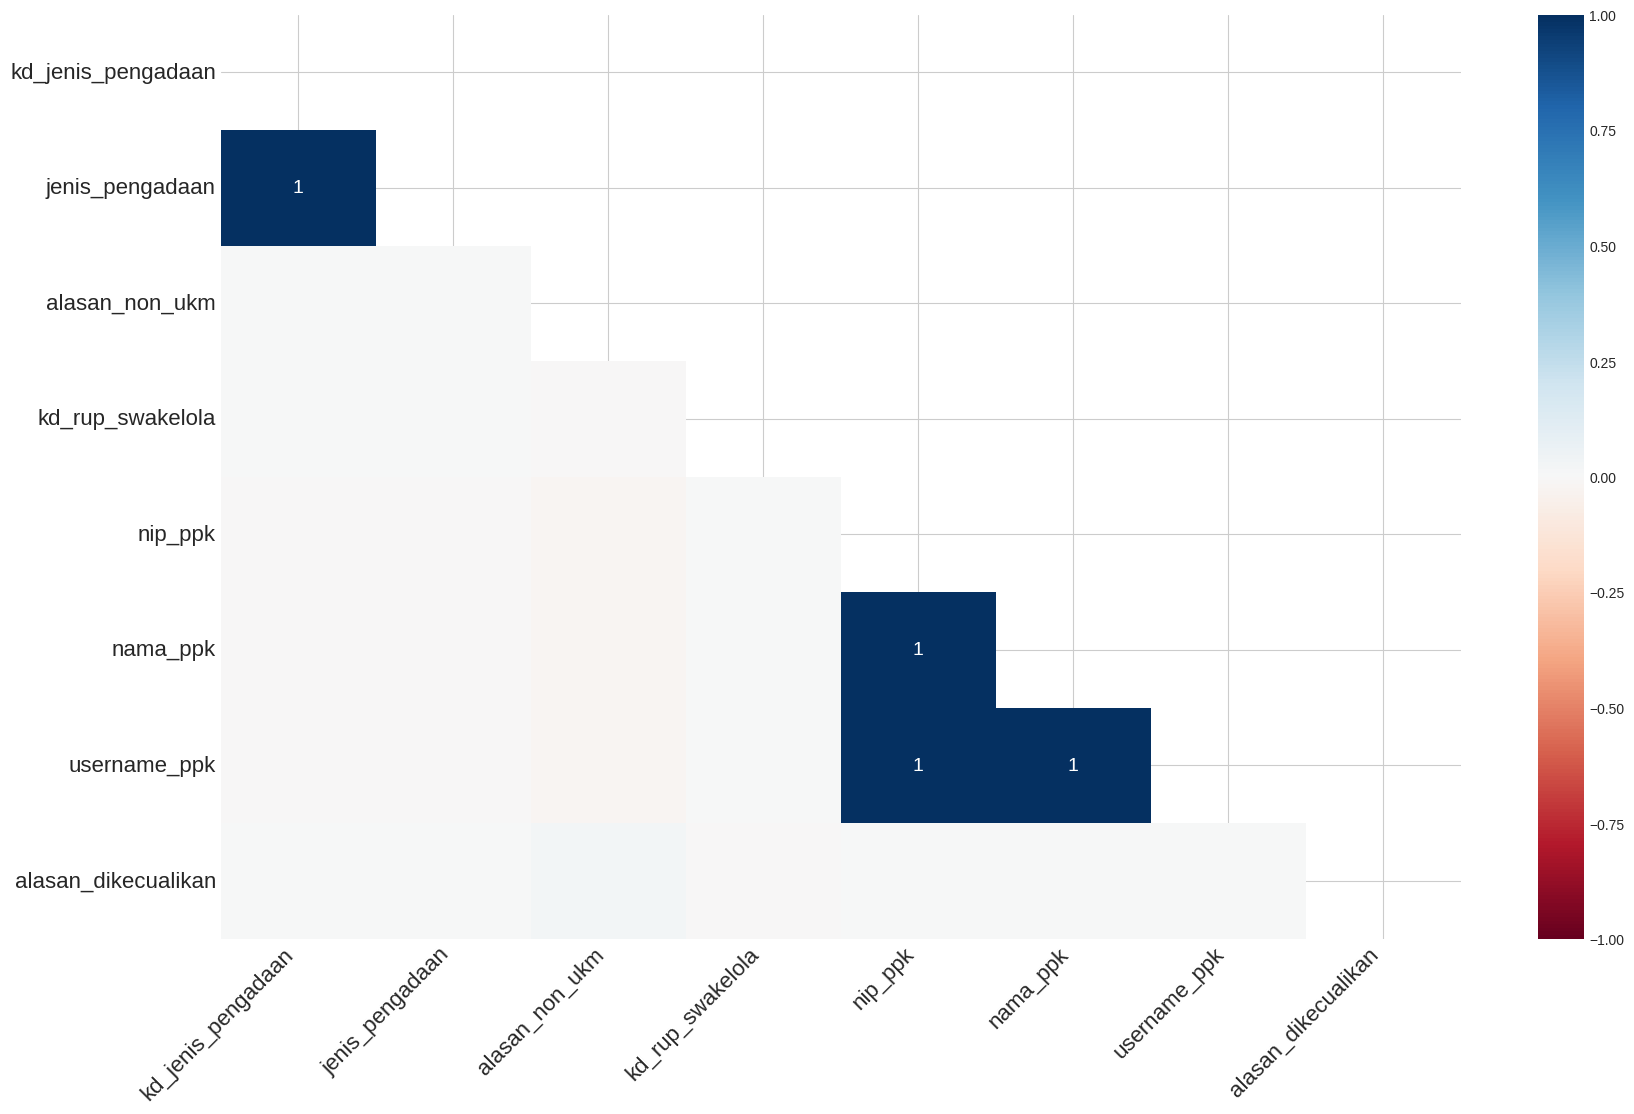

In [24]:
if HAS_MISSINGNO and not missing_summary.empty:
    msno.matrix(df)
    plt.show()
    msno.heatmap(df)
    plt.show()
else:
    if not HAS_MISSINGNO:
        print('ℹ️ missingno tidak tersedia. Jalankan `pip install missingno` untuk visualisasi lanjutan.')

## 🛠️ Missing Value Treatment

In [25]:
df_clean = df.copy()

cols_drop = missing_summary[missing_summary['missing_pct'] > 50].index.tolist()
if cols_drop:
    df_clean = df_clean.drop(columns=cols_drop)
    print(f'Dropped columns >50% missing: {cols_drop}')
else:
    print('Tidak ada kolom dengan missing >50%.')

for col in df_clean.select_dtypes(include=[np.number]).columns:
    if df_clean[col].isnull().any():
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"Filled {col} dengan median {median_val:,.0f}")

for col in df_clean.select_dtypes(include=['object']).columns:
    if df_clean[col].isnull().any():
        df_clean[col].fillna('Unknown', inplace=True)
        print(f"Filled {col} dengan 'Unknown'")

print('Sisa missing values:', df_clean.isnull().sum().sum())

Dropped columns >50% missing: ['kode_rup_tahun_pertama', 'nomor_kontrak', 'tahun_pertama', 'kd_rup_lokal', 'kd_rup_swakelola', 'alasan_non_ukm', 'alasan_dikecualikan']
Filled kd_jenis_pengadaan dengan 'Unknown'
Filled jenis_pengadaan dengan 'Unknown'
Filled nip_ppk dengan 'Unknown'
Filled nama_ppk dengan 'Unknown'
Filled username_ppk dengan 'Unknown'
Sisa missing values: 0


## 📈 Outlier Detection

IQR bounds: -134,201,112 -- 227,295,188
Outliers detected: 621 (3.78%)


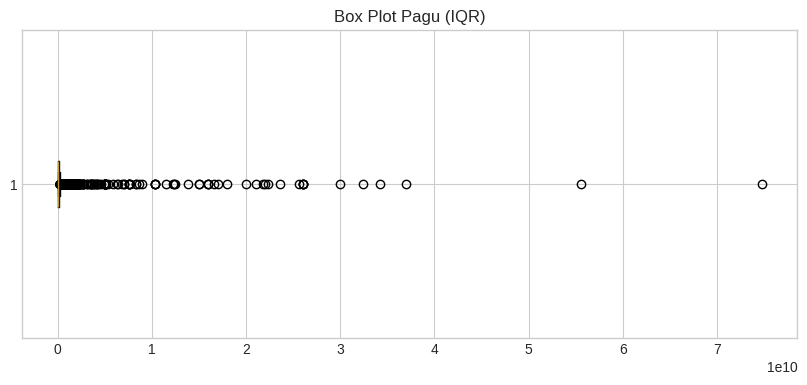

In [26]:
def detect_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    mask = (series < lower) | (series > upper)
    return lower, upper, mask

if 'pagu' in df_clean.columns:
    lower, upper, mask = detect_iqr(df_clean['pagu'])
    print(f'IQR bounds: {lower:,.0f} -- {upper:,.0f}')
    print(f'Outliers detected: {mask.sum()} ({mask.mean()*100:.2f}%)')
    plt.figure(figsize=(10,4))
    plt.boxplot(df_clean['pagu'], vert=False)
    plt.title('Box Plot Pagu (IQR)')
    plt.show()

Outliers (Z > 3): 69


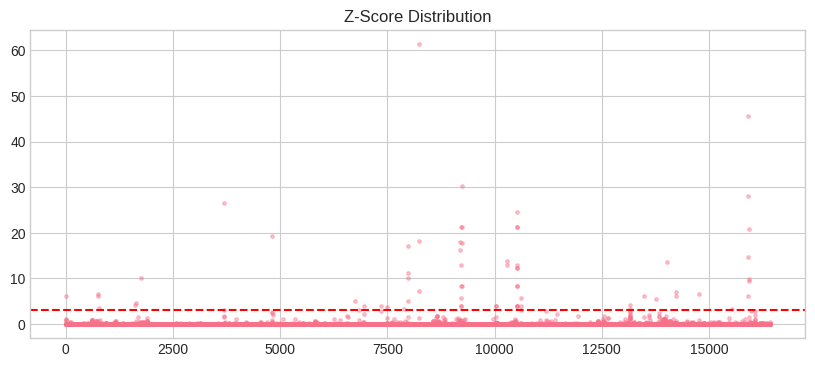

In [27]:
if 'pagu' in df_clean.columns:
    z_scores = np.abs(stats.zscore(df_clean['pagu'].dropna()))
    threshold = 3
    outlier_idx = np.where(z_scores > threshold)[0]
    print(f'Outliers (Z > {threshold}): {len(outlier_idx)}')
    plt.figure(figsize=(10,4))
    plt.scatter(range(len(z_scores)), z_scores, s=6, alpha=0.4)
    plt.axhline(threshold, color='red', linestyle='--')
    plt.title('Z-Score Distribution')
    plt.show()

### Treatment: Remove · Cap · Transform

In [28]:
if 'pagu' in df_clean.columns:
    df_no_outliers = df_clean[(df_clean['pagu'] >= lower) & (df_clean['pagu'] <= upper)]
    df_clean['pagu_capped'] = df_clean['pagu'].clip(lower, upper)
    df_clean['pagu_log'] = np.log1p(df_clean['pagu'])
    df_clean['pagu_sqrt'] = np.sqrt(df_clean['pagu'])

## 🔁 Duplicate Handling

In [29]:
duplicates = df_clean.duplicated().sum()
print('Duplicate rows:', duplicates)
if duplicates:
    df_clean = df_clean.drop_duplicates()
    print('Duplicates removed.')

Duplicate rows: 0


## 🏷️ Encoding Categorical Variables

In [30]:
from sklearn.preprocessing import LabelEncoder

if 'metode_pengadaan' in df_clean.columns:
    le = LabelEncoder()
    df_clean['metode_pengadaan_le'] = le.fit_transform(df_clean['metode_pengadaan'])

one_hot_targets = [col for col in ['metode_pengadaan','jenis_pengadaan'] if col in df_clean.columns]
if one_hot_targets:
    df_clean = pd.concat([df_clean, pd.get_dummies(df_clean[one_hot_targets], prefix=one_hot_targets)], axis=1)

if 'nama_satker' in df_clean.columns:
    freq_map = df_clean['nama_satker'].value_counts().to_dict()
    df_clean['nama_satker_freq'] = df_clean['nama_satker'].map(freq_map)

## 🧪 Feature Engineering

In [31]:
if 'tgl_pengumuman_paket' in df_clean.columns:
    df_clean['tgl_pengumuman_paket'] = pd.to_datetime(df_clean['tgl_pengumuman_paket'], errors='coerce')
    df_clean['year'] = df_clean['tgl_pengumuman_paket'].dt.year
    df_clean['month'] = df_clean['tgl_pengumuman_paket'].dt.month
    df_clean['quarter'] = df_clean['tgl_pengumuman_paket'].dt.quarter
    df_clean['day_of_week'] = df_clean['tgl_pengumuman_paket'].dt.dayofweek
    df_clean['is_weekend'] = df_clean['day_of_week'].isin([5,6]).astype(int)
    df_clean['is_month_end'] = df_clean['tgl_pengumuman_paket'].dt.is_month_end.astype(int)

In [32]:
if 'pagu' in df_clean.columns:
    bins = [0, 100_000_000, 1_000_000_000, 5_000_000_000, float('inf')]
    labels = ['Sangat Kecil','Kecil','Sedang','Besar']
    df_clean['pagu_category'] = pd.cut(df_clean['pagu'], bins=bins, labels=labels)
    print(df_clean['pagu_category'].value_counts())

pagu_category
Sangat Kecil    12737
Kecil            3512
Sedang            130
Besar              51
Name: count, dtype: int64


In [15]:
if 'nama_paket' in df_clean.columns:
    df_clean['nama_paket_length'] = df_clean['nama_paket'].str.len()
    df_clean['nama_paket_word_count'] = df_clean['nama_paket'].str.split().str.len()
    df_clean['contains_konstruksi'] = df_clean['nama_paket'].str.contains('Konstruksi', case=False, na=False).astype(int)

## 📋 Data Quality Report

In [16]:
print('='*70)
print('DATA CLEANING SUMMARY')
print('='*70)
print(f"Original shape: {df_raw.shape}")
print(f"Cleaned shape:  {df_clean.shape}")
print(f"Missing (original): {df_raw.isnull().sum().sum()}")
print(f"Missing (clean):    {df_clean.isnull().sum().sum()}")
print(f"Duplicates removed: {len(df_raw) - len(df_clean)}")
new_cols = sorted(set(df_clean.columns) - set(df_raw.columns))
print('New columns:', new_cols)

DATA CLEANING SUMMARY
Original shape: (16430, 48)
Cleaned shape:  (16430, 70)
Missing (original): 114729
Missing (clean):    0
Duplicates removed: 0
New columns: ['contains_konstruksi', 'day_of_week', 'is_month_end', 'is_weekend', 'jenis_pengadaan_Barang', 'jenis_pengadaan_Barang;Barang', 'jenis_pengadaan_Jasa Konsultansi', 'jenis_pengadaan_Jasa Lainnya', 'jenis_pengadaan_Pekerjaan Konstruksi', 'jenis_pengadaan_Unknown', 'metode_pengadaan_Dikecualikan', 'metode_pengadaan_E-Purchasing', 'metode_pengadaan_Kontes', 'metode_pengadaan_Pengadaan Langsung', 'metode_pengadaan_Penunjukan Langsung', 'metode_pengadaan_Seleksi', 'metode_pengadaan_Tender', 'metode_pengadaan_Tender Cepat', 'metode_pengadaan_le', 'month', 'nama_paket_length', 'nama_paket_word_count', 'nama_satker_freq', 'pagu_capped', 'pagu_category', 'pagu_log', 'pagu_sqrt', 'quarter', 'year']


## 💾 Export Cleaned Dataset

In [17]:
output_dir = Path('../outputs')
output_dir.mkdir(parents=True, exist_ok=True)
output_path = output_dir / 'rup_cleaned.parquet'
df_clean.to_parquet(output_path, index=False)
print(f'Saved cleaned data to {output_path}')

Saved cleaned data to ../outputs/rup_cleaned.parquet


## ✅ Key Takeaways
- Dokumentasikan keputusan cleaning & simpan data mentah
- Kombinasikan strategi drop/fill/transform sesuai konteks
- Feature engineering meningkatkan kualitas analisis lanjutan